# Disaster Response Message Training Data Exploration

Explore training disaster response message training dataset provided by Figure Eight [https://www.figure-eight.com/].

In [126]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [116]:
conn = sqlite3.connect('../data/DisasterResponse.db')
df = pd.read_sql_query('SELECT * FROM message', conn, index_col='id')

In [117]:
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that c...,direct,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country ...",direct,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check if all messages classified as `related==0` are classified as not belonging to any categories

In [118]:
num_cats_df = pd.DataFrame(df.loc[:, 'related':].sum(axis=1), columns=['num_categories'])\
                .merge(df[['related']], on='id')
num_cats_df

,num_categories,related
id,,
2,1,1
7,5,1
8,1,1
9,8,1
12,1,1
...,...,...
30261,0,0
30262,0,0
30263,1,1


In [119]:
num_cats_df[num_cats_df.related == 0].sum()

num_categories    0
related           0
dtype: int64

We have confirmed that all uncategorized messages have `related == 0`.  

Plot distribution of messages into categories.

In [195]:
# Add column uncategorized
df['uncategorized'] = np.where(df.related == 0, 1, 0)
cat_counts = df.loc[:, 'request':].sum().sort_values(ascending=False)
cat_counts.head()

aid_related        10840
weather_related     7286
uncategorized       6114
direct_report       5063
request             4464
dtype: int64

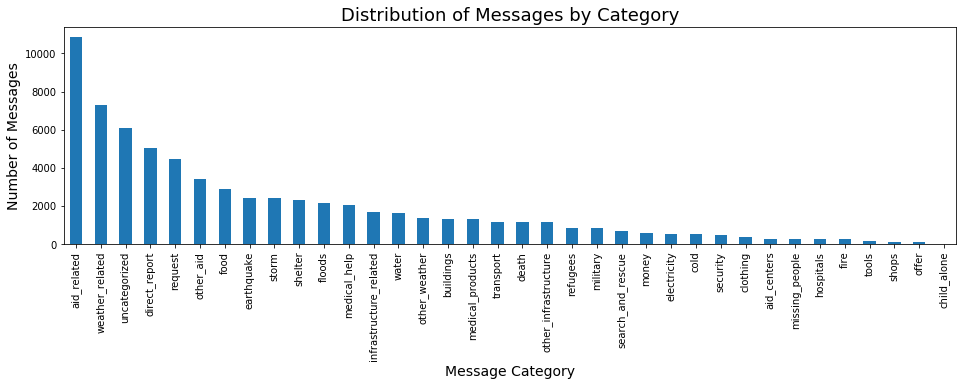

In [146]:
# plot all 
cat_counts.plot(kind='bar', figsize=(16,4))
plt.title('Distribution of Messages by Category', fontsize=18)
plt.xlabel('Message Category', fontsize=14)
plt.ylabel('Number of Messages', fontsize=14);

In [158]:
corr = df.loc[:, 'request':].corr()
cat_names = [x.replace('_', ' ').title() for x in corr.index.values]

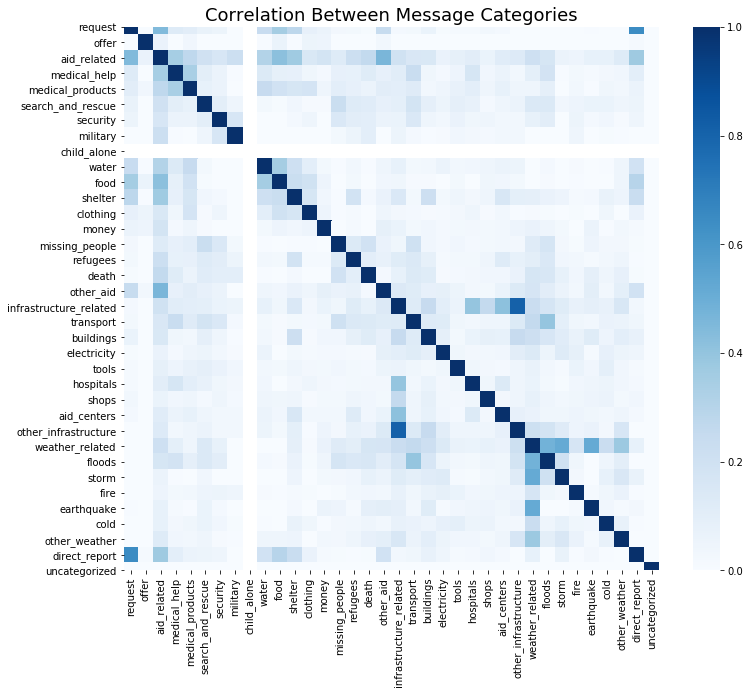

In [140]:
# Correlation between categories
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(df.loc[:, 'request':].corr(), vmin=0, vmax=1, cmap='Blues')
ax.set_title('Correlation Between Message Categories', fontsize=18);

For each category plot source of messages as percent of all messages belonging to this category.

In [190]:
summary = df.groupby('genre').agg('sum').T
summary.head()

genre,direct,news,social
related,7298,10673,2089
request,3687,604,173
offer,46,64,7
aid_related,4328,5851,661
medical_help,590,1413,77


In [191]:
for col in summary:
    summary[col + 'pct'] = 100.0 * summary[col] / (summary.direct + summary.news + summary.social)
summary.drop('related', inplace=True)
summary.head()

genre,direct,news,social,directpct,newspct,socialpct
request,3687,604,173,82.594086,13.530466,3.875448
offer,46,64,7,39.316239,54.700855,5.982906
aid_related,4328,5851,661,39.926199,53.976015,6.097786
medical_help,590,1413,77,28.365385,67.932692,3.701923
medical_products,470,791,49,35.877863,60.381679,3.740458


In [199]:
summary = summary.reindex(cat_counts.index.to_list())

In [200]:
summary.index

Index(['aid_related', 'weather_related', 'uncategorized', 'direct_report',
       'request', 'other_aid', 'food', 'earthquake', 'storm', 'shelter',
       'floods', 'medical_help', 'infrastructure_related', 'water',
       'other_weather', 'buildings', 'medical_products', 'transport', 'death',
       'other_infrastructure', 'refugees', 'military', 'search_and_rescue',
       'money', 'electricity', 'cold', 'security', 'clothing', 'aid_centers',
       'missing_people', 'hospitals', 'fire', 'tools', 'shops', 'offer',
       'child_alone'],
      dtype='object')

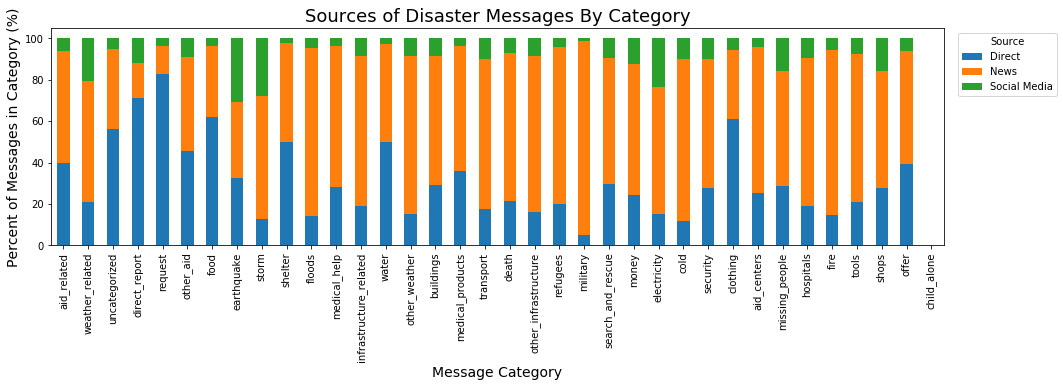

In [201]:
summary[['directpct', 'newspct', 'socialpct']].plot(kind='bar', stacked=True, figsize=(16, 4))
plt.legend(['Direct', 'News', 'Social Media'], title='Source', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel('Message Category', fontsize=14)
plt.ylabel('Percent of Messages in Category (%)', fontsize=14)
plt.title('Sources of Disaster Messages By Category', fontsize=18);

In [185]:
summary

genre,direct,news,social,directpct,newspct,socialpct
request,3687,604,173,82.594086,13.530466,3.875448
offer,46,64,7,39.316239,54.700855,5.982906
aid_related,4328,5851,661,39.926199,53.976015,6.097786
medical_help,590,1413,77,28.365385,67.932692,3.701923
medical_products,470,791,49,35.877863,60.381679,3.740458
search_and_rescue,216,441,67,29.834254,60.911602,9.254144
security,131,292,48,27.813163,61.995754,10.191083
military,45,801,13,5.238650,93.247963,1.513388
child_alone,0,0,0,NaN,NaN,NaN
water,834,789,46,49.970042,47.273817,2.756141
